# Exercise - Stripping Caps


#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$


# 1. Pricing Floors


### Data

The file `data/cap_curves_2025-06-30.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.


### 1.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Load curve data
curve = (
    pd.read_excel(
        "cap_curves_2025-06-30.xlsx",
        sheet_name="rate curves 2025-06-30",
    )
    .set_index("tenor")
    .sort_index()
)


def interp_linear(series: pd.Series, x: float) -> float:
    """Linear interpolation for a 1D curve indexed by tenor (in years)."""
    if x in series.index:
        return float(series.loc[x])
    xs = series.index.to_numpy(dtype=float)
    ys = series.to_numpy(dtype=float)
    return float(np.interp(x, xs, ys))


# Floorlet specs
T_pay = 3.00
coupon_freq = 4
alpha = 1.0 / coupon_freq
T_reset = T_pay - alpha  # rate is observed one quarter before payment
notional = 100.0

# Inputs from the curve
P0_T = interp_linear(curve["discounts"].astype(float), T_pay)  # discount to payment
F = interp_linear(curve["forwards"].astype(float), T_pay)  # forward for [T-0.25, T]
K = interp_linear(curve["swap rates"].astype(float), T_pay)  # strike = 3Y swap rate
sigma = interp_linear(curve["flat vols"].astype(float), T_pay)  # use the flat cap vol @ T
sigma = sigma / 100.0 if sigma > 3.0 else sigma  # handle % vs decimal quotes

# Black (lognormal) floorlet PV = N * alpha * P(0,T) * PutBlack(F,K,sigma,T_reset)
vol_sqrt_t = sigma * np.sqrt(T_reset)
d1 = (np.log(F / K) + 0.5 * sigma * sigma * T_reset) / vol_sqrt_t
d2 = d1 - vol_sqrt_t
black_put = K * norm.cdf(-d2) - F * norm.cdf(-d1)

floorlet_pv = notional * alpha * P0_T * black_put

print(f"Floorlet payment T     = {T_pay:.2f}y")
print(f"Reset (option) time    = {T_reset:.2f}y")
print(f"Notional               = {notional:.2f}")
print(f"Accrual alpha          = {alpha:.2f}")
print(f"Discount P(0,T)        = {P0_T:.6f}")
print(f"Forward F(T-0.25,T)    = {F:.6%}")
print(f"Strike K (3Y swap rate)= {K:.6%}")
print(f"Vol used (flat @3y)    = {sigma:.2%}")
print(f"Floorlet PV            = {floorlet_pv:.6f}")


Floorlet payment T     = 3.00y
Reset (option) time    = 2.75y
Notional               = 100.00
Accrual alpha          = 0.25
Discount P(0,T)        = 0.904790
Forward F(T-0.25,T)    = 3.298742%
Strike K (3Y swap rate)= 3.356821%
Vol used (flat @3y)    = 29.47%
Floorlet PV            = 0.151949


### 1.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.


In [2]:
# Entire floor (T=3): sum floorlets at quarterly frequency, excluding the first quarter
# We reuse from 1.1: curve, interp_linear, norm, alpha, notional, K, sigma

T_end = 3.00

# Floorlets start at 0.5y because the market cap/floor strip starts at tau=0.5
pay_times = np.arange(0.50, T_end + 1e-12, alpha)  # 0.50, 0.75, ..., 3.00

rows = []
for T_pay in pay_times:
    T_reset = T_pay - alpha
    P0_T = interp_linear(curve["discounts"].astype(float), float(T_pay))
    F = interp_linear(curve["forwards"].astype(float), float(T_pay))

    vol_sqrt_t = sigma * np.sqrt(T_reset)
    d1 = (np.log(F / K) + 0.5 * sigma * sigma * T_reset) / vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    black_put = K * norm.cdf(-d2) - F * norm.cdf(-d1)

    pv = notional * alpha * P0_T * black_put

    rows.append(
        {
            "T_pay": float(T_pay),
            "T_reset": float(T_reset),
            "P(0,T)": float(P0_T),
            "F": float(F),
            "K": float(K),
            "vol": float(sigma),
            "floorlet_pv": float(pv),
        }
    )

floorlets = pd.DataFrame(rows)
floor_pv = float(floorlets["floorlet_pv"].sum())

print(f"Floor maturity T_end   = {T_end:.2f}y")
print(f"Strike K (3Y swap rate)= {K:.6%}")
print(f"Vol used (flat @3y)    = {sigma:.2%}")
print(f"Notional               = {notional:.2f}")
print(f"Accrual alpha          = {alpha:.2f}")
print(f"Number of floorlets    = {len(floorlets)}")
print(f"Total floor PV         = {floor_pv:.6f}")

display(
    floorlets.style.format(
        {
            "T_pay": "{:.2f}",
            "T_reset": "{:.2f}",
            "P(0,T)": "{:.6f}",
            "F": "{:.6%}",
            "K": "{:.6%}",
            "vol": "{:.2%}",
            "floorlet_pv": "{:.6f}",
        }
    )
)


Floor maturity T_end   = 3.00y
Strike K (3Y swap rate)= 3.356821%
Vol used (flat @3y)    = 29.47%
Notional               = 100.00
Accrual alpha          = 0.25
Number of floorlets    = 11
Total floor PV         = 1.317555


,T_pay,T_reset,"P(0,T)",F,K,vol,floorlet_pv
0,0.50,0.25,0.979883,3.935085%,3.356821%,29.47%,0.009368
1,0.75,0.50,0.971043,3.641418%,3.356821%,29.47%,0.041221
2,1.00,0.75,0.962807,3.421712%,3.356821%,29.47%,0.075248
3,1.25,1.00,0.955417,3.093753%,3.356821%,29.47%,0.125061
4,1.50,1.25,0.948239,3.027984%,3.356821%,29.47%,0.142752
5,1.75,1.50,0.941054,3.054245%,3.356821%,29.47%,0.147216
6,2.00,1.75,0.933835,3.091859%,3.356821%,29.47%,0.149793
7,2.25,2.00,0.926827,3.024803%,3.356821%,29.47%,0.164223
8,2.50,2.25,0.919605,3.141374%,3.356821%,29.47%,0.156857
9,2.75,2.50,0.912252,3.224154%,3.356821%,29.47%,0.153865


# 2. Stripping Caps


### Data

Continue with the file `data/cap_curves_2025-06-30.xlsx`.


### 2.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.


,maturity_T,strike_ATM,flat_vol,cap_pv,cap_pv_bps_of_notional
0,0.50,4.085936%,15.68%,0.015719,1.57
1,0.75,3.939140%,18.07%,0.053574,5.36
2,1.00,3.811507%,20.46%,0.115339,11.53
3,1.25,3.670367%,24.21%,0.214448,21.44
4,1.50,3.565469%,26.86%,0.327791,32.78
5,1.75,3.494175%,28.59%,0.450402,45.04
6,2.00,3.445268%,29.56%,0.578409,57.84
7,2.25,3.399999%,29.96%,0.705708,70.57
8,2.50,3.375038%,29.96%,0.834493,83.45
9,2.75,3.361855%,29.74%,0.964974,96.50


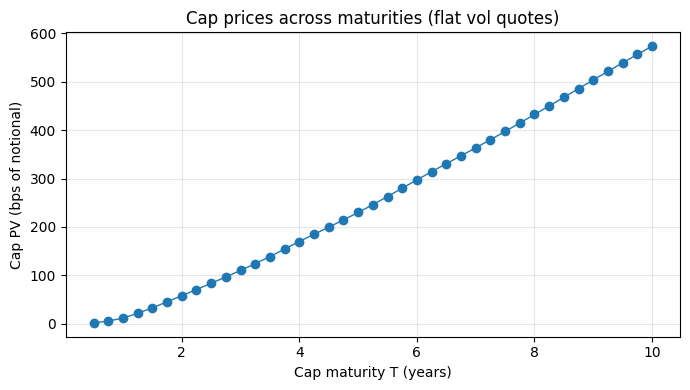

In [3]:
import matplotlib.pyplot as plt


def black_caplet_call_pv(*, fwd: float, strike: float, vol: float, expiry: float, df_pay: float, alpha: float, notional: float) -> float:
    """PV of one caplet under Black: N*alpha*P(0,Tpay)*(F N(d1) - K N(d2)), expiry = reset time."""
    if expiry <= 0 or vol <= 0:
        return float(notional * alpha * df_pay * max(fwd - strike, 0.0))
    if fwd <= 0 or strike <= 0:
        raise ValueError(f"Black caplet requires positive fwd/strike. Got fwd={fwd}, strike={strike}")

    vol_sqrt_t = float(vol * np.sqrt(expiry))
    d1 = (np.log(fwd / strike) + 0.5 * vol * vol * expiry) / vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    return float(notional * alpha * df_pay * (fwd * norm.cdf(d1) - strike * norm.cdf(d2)))


# Cap pricing across maturities using flat vols
notional_cap = 100.0
alpha = 1.0 / 4  # quarterly

maturities = curve.index.to_numpy(dtype=float)
maturities = maturities[(maturities >= 0.50) & (maturities <= 10.00)]

cap_rows = []
for T in maturities:
    # ATM strike for the cap: use the swap rate at maturity T
    K_T = interp_linear(curve["swap rates"].astype(float), float(T))

    # Flat vol quote for the cap expiring at T
    sigma_T = interp_linear(curve["flat vols"].astype(float), float(T))
    sigma_T = sigma_T / 100.0 if sigma_T > 3.0 else sigma_T

    # Cap contains caplets from 0.5y to T (quarterly)
    pay_times = np.arange(0.50, float(T) + 1e-12, alpha)

    cap_pv = 0.0
    for T_pay in pay_times:
        T_reset = float(T_pay - alpha)
        df_pay = interp_linear(curve["discounts"].astype(float), float(T_pay))
        fwd = interp_linear(curve["forwards"].astype(float), float(T_pay))
        cap_pv += black_caplet_call_pv(
            fwd=fwd,
            strike=K_T,
            vol=sigma_T,
            expiry=T_reset,
            df_pay=df_pay,
            alpha=alpha,
            notional=notional_cap,
        )

    cap_rows.append(
        {
            "maturity_T": float(T),
            "strike_ATM": float(K_T),
            "flat_vol": float(sigma_T),
            "cap_pv": float(cap_pv),
            "cap_pv_bps_of_notional": float(cap_pv) * 10_000.0 / notional_cap,
        }
    )

caps = pd.DataFrame(cap_rows)

display(
    caps.style.format(
        {
            "maturity_T": "{:.2f}",
            "strike_ATM": "{:.6%}",
            "flat_vol": "{:.2%}",
            "cap_pv": "{:.6f}",
            "cap_pv_bps_of_notional": "{:.2f}",
        }
    )
)

plt.figure(figsize=(7, 4))
plt.plot(caps["maturity_T"], caps["cap_pv_bps_of_notional"], marker="o", linewidth=1)
plt.xlabel("Cap maturity T (years)")
plt.ylabel("Cap PV (bps of notional)")
plt.title("Cap prices across maturities (flat vol quotes)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.


,T_pay,T_reset,cap_strike,flat_vol_cap_T,df_pay,fwd,caplet_pv,caplet_pv_bps_of_notional,fwd_vol_caplet
0,0.50,0.25,4.085936%,15.68%,0.979883,3.935085%,0.015719,1.57,15.68%
1,0.75,0.50,3.939140%,18.07%,0.971043,3.641418%,0.037856,3.79,26.24%
2,1.00,0.75,3.811507%,20.46%,0.962807,3.421712%,0.061764,6.18,34.03%
3,1.25,1.00,3.670367%,24.21%,0.955417,3.093753%,0.099110,9.91,49.83%
4,1.50,1.25,3.565469%,26.86%,0.948239,3.027984%,0.113343,11.33,49.35%
5,1.75,1.50,3.494175%,28.59%,0.941054,3.054245%,0.122611,12.26,45.65%
6,2.00,1.75,3.445268%,29.56%,0.933835,3.091859%,0.128007,12.80,41.79%
7,2.25,2.00,3.399999%,29.96%,0.926827,3.024803%,0.127298,12.73,40.40%
8,2.50,2.25,3.375038%,29.96%,0.919605,3.141374%,0.128785,12.88,34.80%
9,2.75,2.50,3.361855%,29.74%,0.912252,3.224154%,0.130481,13.05,31.06%


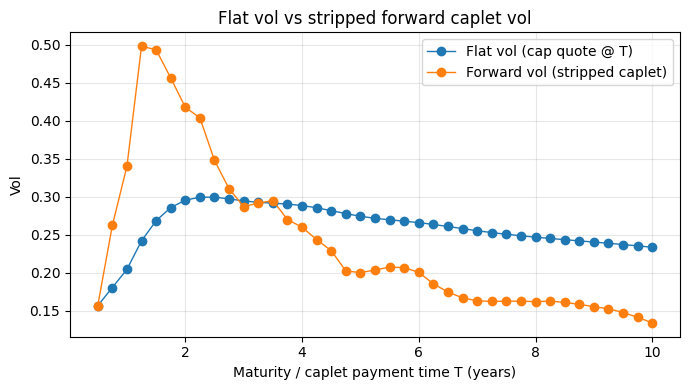

In [4]:
from scipy.optimize import brentq

# 2.2 Strip caplet PVs from cap PVs, then back out forward vols per caplet
# Requires outputs from 2.1: `caps`, `curve`, `black_caplet_call_pv`, `alpha`, `notional_cap`

if "caps" not in globals():
    raise NameError("Run 2.1 first to create `caps`.")

cap_pv_by_T = dict(zip(caps["maturity_T"].astype(float), caps["cap_pv"].astype(float)))
strike_by_T = dict(zip(caps["maturity_T"].astype(float), caps["strike_ATM"].astype(float)))
flatvol_by_T = dict(zip(caps["maturity_T"].astype(float), caps["flat_vol"].astype(float)))

T_grid = np.array(sorted(cap_pv_by_T.keys()), dtype=float)
T_grid = T_grid[(T_grid >= 0.50) & (T_grid <= 10.00)]


def implied_vol_caplet(*, pv: float, fwd: float, strike: float, expiry: float, df_pay: float, alpha: float, notional: float) -> float:
    """Invert Black caplet call PV for sigma (forward vol)."""
    intrinsic = float(notional * alpha * df_pay * max(fwd - strike, 0.0))
    if pv <= intrinsic + 1e-14:
        return 0.0

    def obj(sig: float) -> float:
        return black_caplet_call_pv(
            fwd=fwd,
            strike=strike,
            vol=sig,
            expiry=expiry,
            df_pay=df_pay,
            alpha=alpha,
            notional=notional,
        ) - pv

    # price is increasing in sigma, so brentq is safe with wide bounds
    return float(brentq(obj, 1e-12, 5.0, maxiter=200))


caplet_rows = []
for T_pay in T_grid:
    T_pay = float(T_pay)
    T_prev = float(T_pay - alpha)

    cap_pv = float(cap_pv_by_T[T_pay])
    cap_pv_prev = float(cap_pv_by_T.get(T_prev, 0.0))
    caplet_pv = cap_pv if abs(T_pay - 0.50) < 1e-12 else (cap_pv - cap_pv_prev)

    strike = float(strike_by_T[T_pay])
    flat_vol = float(flatvol_by_T[T_pay])
    df_pay = interp_linear(curve["discounts"].astype(float), T_pay)
    fwd = interp_linear(curve["forwards"].astype(float), T_pay)
    expiry = float(T_pay - alpha)

    fwd_vol = implied_vol_caplet(
        pv=caplet_pv,
        fwd=fwd,
        strike=strike,
        expiry=expiry,
        df_pay=df_pay,
        alpha=alpha,
        notional=notional_cap,
    )

    caplet_rows.append(
        {
            "T_pay": T_pay,
            "T_reset": expiry,
            "cap_strike": strike,
            "flat_vol_cap_T": flat_vol,
            "df_pay": df_pay,
            "fwd": fwd,
            "caplet_pv": caplet_pv,
            "caplet_pv_bps_of_notional": caplet_pv * 10_000.0 / notional_cap,
            "fwd_vol_caplet": fwd_vol,
        }
    )

caplets = pd.DataFrame(caplet_rows)

display(
    caplets.style.format(
        {
            "T_pay": "{:.2f}",
            "T_reset": "{:.2f}",
            "cap_strike": "{:.6%}",
            "flat_vol_cap_T": "{:.2%}",
            "df_pay": "{:.6f}",
            "fwd": "{:.6%}",
            "caplet_pv": "{:.6f}",
            "caplet_pv_bps_of_notional": "{:.2f}",
            "fwd_vol_caplet": "{:.2%}",
        }
    )
)

# Compare forward vol vs flat vol
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(caplets["T_pay"], caplets["flat_vol_cap_T"], marker="o", linewidth=1, label="Flat vol (cap quote @ T)")
plt.plot(caplets["T_pay"], caplets["fwd_vol_caplet"], marker="o", linewidth=1, label="Forward vol (stripped caplet)")
plt.xlabel("Maturity / caplet payment time T (years)")
plt.ylabel("Vol")
plt.title("Flat vol vs stripped forward caplet vol")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
